In [1]:
# Activate the library
import Pkg
Pkg.activate("../")

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [25]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Random", "QuadGK", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

# Exploration: Looking for the relaxation time
I will be using a model of radiative damping since it's easy to obtains it's FI. Particularly, I found that:

$$ F(\gamma) = \frac{1-e^{-\gamma T}}{\gamma^2}. $$

The first thing I want to know is how long I should look, for that I test the relaxation time.

In [26]:
EPS = 0e-5 # Tolerance for the distance respect to the Frobenious norm
delta= 0 # Detuning
omega = 0.0 # Rabi Frequency
gamma = 0.5
H = delta*QuTaM.sigma_z + omega*QuTaM.sigma_x

psi0 = zeros(ComplexF64, 2)
psi0[2] = 1 # Initial condition

sys = System(H, # Hamiltonian
[sqrt(gamma)*QuTaM.sigma_m]) #Jump Operators
params = SimulParameters(psi0,
    150.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    10_000, # Number of trajectories
    100_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)

SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=100000
seed=1
ntraj=10000)
multiplier=4.0
tf=150.0
dt=0.006
eps=0.001)

In [27]:
function rf_de!(dr, r, p, t)
    #gamma = QuTaM.rf_gamma
    #delta = QuTaM.rf_delta
    #omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [28]:
r0 = [0.0; 0.0; 1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [29]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [30]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

Sampling... 100%|████████████████████████████████████████| Time: 0:06:58


In [31]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

 34.486937 seconds (412.00 M allocations: 14.636 GiB, 4.26% gc time, 0.28% compilation time)


In [32]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.052936 seconds (62.29 k allocations: 2.007 MiB, 92.44% compilation time)


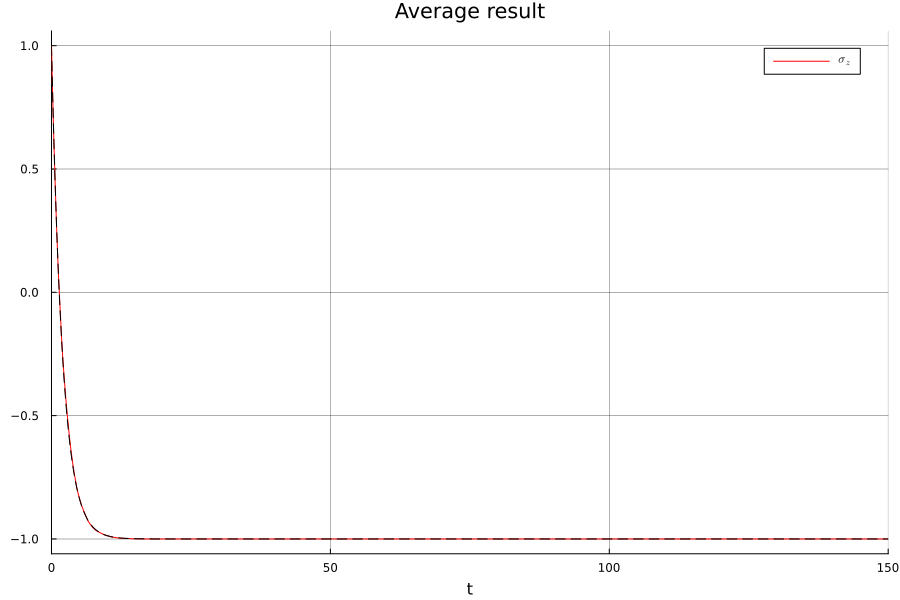

In [33]:
index_range = 1:size(t_given)[1]

#plot(sol[index_range], idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
#plot!(t_given[index_range], r_avg[index_range, 1],  label=L"\sigma_x" , seriescolor=:blue)
#
#plot!(t_given[index_range], r_avg[index_range, 2],  label=L"\sigma_y" , seriescolor=:green)
#plot!(sol[index_range], idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)

plot(t_given[index_range], r_avg[index_range, 3],  label=L"\sigma_z" , seriescolor=:red)
plot!(sol[index_range], idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)

plot!(title="Average result", xlabel="t", grid=:true, gridalpha=0.6, size=(900,600))

# Calculating the Monitoring Operator
The key to access the FI is to use the monitoring operator:

$$ |\xi_N(t_n,...,t_1)\rangle = \frac{\partial_\theta|\psi(t_n, ...,t_1) \rangle}{\langle\psi(t_n, ...,t_1)|\psi(t_n, ...,t_1) \rangle}$$

so the first thing in order is to obtain this thing, conditioned on a trajectory.

In [34]:
traj = sample_clicks[3]
QuTaM.states_at_jumps(traj, sys, params.psi0; normalize=false)

1×2 Matrix{ComplexF64}:
 0.269933+0.0im  0.0+0.0im

In [35]:
function DerivativeAtJumps(traj::Trajectory, sys::System, dHe::Matrix{ComplexF64}, dLs::Vector{Matrix{ComplexF64}},
         params::SimulParameters) 
    njumps = size(traj)[1]
    dpsis = zeros(ComplexF64, njumps, sys.NLEVELS)
    tmp1 = zeros(ComplexF64, sys.NLEVELS) #for the psitilde
    tmp2 = zeros(ComplexF64, sys.NLEVELS) #for the derivative of psitilde
    #  intialize the monitoring
    label = traj[1].label
    tau = traj[1].time
    tmp1 .= psi0
    #  Iterate over the clicks
    for k in 1:njumps
        label = traj[k].label
        tau = traj[k].time
        # 1. Calculate the derivative  
        tmp2 .= dLs[label]*exp(-1im*tau*sys.Heff)*tmp1 + 
                sys.Ls[label]*-1im*tau*dHe*exp(-1im*tau*sys.Heff)*tmp1+
                sys.Ls[label]*exp(-1im*tau*sys.Heff)*tmp2
        dpsis[k, :] = tmp2
        # 2. Calculate the psitilde
        tmp1 .= sys.Ls[label]*exp(-1im*tau*sys.Heff)*tmp1 
    end 
    return dpsis
end 

DerivativeAtJumps (generic function with 1 method)

In [36]:
traj = sample_clicks[30]
dHe = -0.5im * QuTaM.sigma_p * QuTaM.sigma_m
dLs = [0.5*1/(sqrt(gamma))*QuTaM.sigma_m]

1-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.7071067811865475 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

In [37]:
"""

MonitoringInBetween( traj::Trajectory, sys::System, dHe::Matrix{ComplexF64},
                     params::SimulParameters,
                    t_given::Vector{Float64}) -> Array{ComplexF64}

- `t_given::Vector{Float64}`: times at which the trajectory is to be evalauted
- `traj::Trajectory`: the trajectory
- `sys::System`: the system to which the trajectory corresponds
- `psi0::Vector{ComplexF63}`: the initial state of the trajectory
- `dHe::Matrix{ComplexF64}`
- `dLs::Vector{Matrix{ComplexF63}}`
"""
function MonitoringInBetween(
        traj::Trajectory, sys::System, dHe::Matrix{ComplexF64}, dLs::Vector{Matrix{ComplexF64}},
         params::SimulParameters, t_given::Vector{Float64}) 
    ntimes = size(t_given)[1]
    tmp1 = zeros(ComplexF64, sys.NLEVELS)
    psitilde = zeros(ComplexF64, sys.NLEVELS)
    # Obtain the unnormalized jump states
    jump_states = states_at_jumps(traj, sys, psi0; normalize=false)
    inbetween_states = evaluate_at_t(t_given, traj, sys, psi0; normalize=false)
    jump_dpsis= DerivativeAtJumps(traj, sys, dHe, dLs, params)
    njumps = size(jump_states)[1]
    t_ = 0
    counter = 1
    counter_c = 1
    # Edge case: if the time array is empty, return an empty array
    if isempty(t_given)
        return Array{ComplexF64}(undef, 0, 0) # empty 2 dimensional array
    end

    xis = Array{ComplexF64}(undef, ntimes, sys.NLEVELS, sys.NLEVELS)
    #Edge case: if the trajectory is empty
     if isempty(traj)
        while counter <= ntimes
            # 1. Calculate the derivative
            tmp1 .= -1im*(t_given[counter])*dHe*inbetween_states[counter, :]
            # 2. take the outer products and normalize
            xis[counter, :, :] = (adjoint(tmp1) .* inbetween_states[counter, : ] +
                               adjoint(inbetween_states[counter, : ]) .* tmp1) / dot(inbetween_states[counter, :], inbetween_states[counter, :])
            counter = counter + 1
            if counter > ntimes
                break
            end
        end
        return xis
    end
    # All the xis before the first jump can be handled like this:
    while (t_given[counter] < traj[counter_c].time) && (counter <= ntimes)
            # 1. Calculate the derivative
            tmp1 .= -1im*(t_given[counter])*dHe*inbetween_states[counter, :]
            # 2. normalize and add
            xis[counter, :, :] = (adjoint(tmp1) .* inbetween_states[counter, : ] +
                               adjoint(inbetween_states[counter, : ]) .* tmp1) / dot(inbetween_states[counter, :], inbetween_states[counter, :])
            counter = counter + 1
            if counter > ntimes
                break
            end
    end
    t_ = t_ + traj[counter_c].time
    counter_c = counter_c + 1
    # In between jumps
    while (counter_c <= njumps) && (counter <= ntimes)
        timeclick = traj[counter_c].time
        while (t_ < t_given[counter] < t_ + timeclick) && (counter <= ntimes)
             # 1. Calculate the derivative
             tmp1 .= -1im*(t_given[counter]-t_)*dHe*jump_states[counter_c, :] + 
                     exp(-1im*(t_given[counter]-t_)*sys.Heff)*jump_dpsis[counter_c, :]
             xis[counter, :, :] = (adjoint(tmp1) .* inbetween_states[counter, : ] +
                               adjoint(inbetween_states[counter, : ]) .* tmp1) / dot(inbetween_states[counter, :], inbetween_states[counter, :])
             counter = counter + 1
             if counter > ntimes
                 break
             end
         end
       t_ = t_ + timeclick
       counter_c = counter_c + 1
    end
    # After all the jumps finished
    while counter <= ntimes
        tmp1 .= -1im*(t_given[counter]-t_)*dHe*inbetween_states[counter, : ] + 
               exp(-1im*(t_given[counter]-t_)*sys.Heff)*jump_dpsis[end, :]
         xis[counter, :, :] = (adjoint(tmp1) .* inbetween_states[counter, : ] +
                               adjoint(inbetween_states[counter, : ]) .* tmp1) / dot(inbetween_states[counter, :], inbetween_states[counter, :])
        counter = counter + 1
    end
    return xis 
end
 

MonitoringInBetween

In [38]:
sample_xi = zeros(ComplexF64, ntimes, sys.NLEVELS, sys.NLEVELS, params.ntraj)
for k in 1:params.ntraj
    sample_xi[:, :, :, k] = MonitoringInBetween(sample_clicks[k], sys, dHe, dLs, params, t_given);
end 

In [39]:
fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
for k in 1:params.ntraj
    for tn in 1:ntimes
        fi_sample[tn, k] = real(tr(sample_xi[tn, :, :, k]))^2
    end 
end 

In [40]:
jump_index = 1
while t_given[jump_index] < traj[1].time
    jump_index = jump_index + 1
end
jump_index

12

In [41]:
FI = dropdims(mean(fi_sample, dims=2), dims=2);

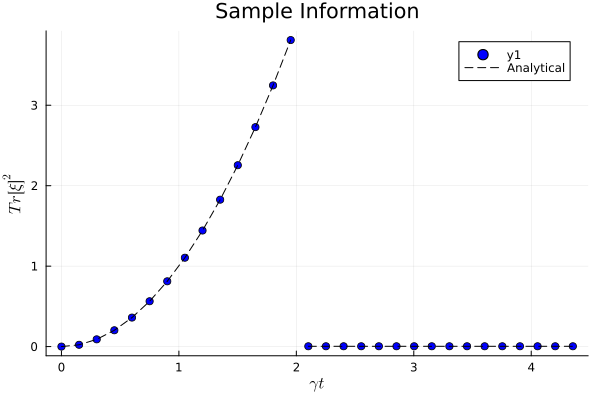

In [42]:
trajindex = 40
jump_index = 1 
while t_given[jump_index] < sample_clicks[trajindex][1].time
    jump_index = 1 + jump_index
end 
pre_jump_range = 1:(jump_index-1)
post_jump_range = jump_index:30
t_prejump = t_given[pre_jump_range]
fi_prejump = fi_sample[pre_jump_range, trajindex]

scatter(t_prejump, fi_prejump, color="blue", title="Sample Information", xlabel=L"\gamma t",
    ylabel=L"Tr[\xi]^2")
plot!(t_prejump, t_prejump.^2, label="Analytical", line=:dash, color="black")

t_postjump = t_given[post_jump_range]
fi_postjump = fi_sample[post_jump_range, trajindex]
analytical_postjump = ones(Float64, size(t_postjump)) * ((1-gamma*sample_clicks[trajindex][1].time)/ gamma )^2

scatter!(t_postjump, fi_postjump, color="blue", label=false)
plot!(t_postjump, analytical_postjump, label=false, line=:dash, color="black", )

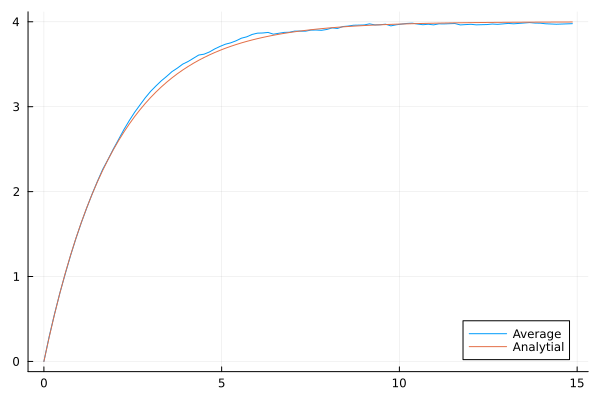

In [43]:
plot(t_given[1:100], FI[1:100], label="Average")
plot!(t_given[1:100], (1.0.-exp.(-gamma*t_given[1:100]))./gamma^2, label="Analytial")